In [109]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point


In [110]:
gdf = gpd.read_file('data/WesternUSCensusTract/CensusTract2020_WesternUS.shp')

/Users/kate/dev/concurrence-climate-hazards/.venv/lib/python3.11/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [111]:
unique_state = gdf['STATE_FIPS'].unique()
state_list = [int(x) for x in unique_state]

In [112]:
# Print the current CRS (datum)
print("Current CRS:", gdf.crs)

# Define the target CRS (e.g., EPSG code)
target_crs = "EPSG:4326"  # WGS84

# Convert the GeoDataFrame to the target CRS
gdf_converted = gdf.to_crs(target_crs)


Current CRS: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]


In [113]:
df = pd.read_csv("data/annual_conc_by_monitor_2023.csv")
df2 =  df.loc[df['Parameter Code'] == 88101]
df3 =  df2.loc[df['Pollutant Standard'] == 'PM25 Annual 2012']
df4 = df3.loc[df['State Code'].isin(state_list)]
df4 = df4.drop(df4[df4['State Name']== 'Texas'].index)

In [114]:
geometry = gpd.points_from_xy(df4.Longitude, df4.Latitude)
df4_gdf = gpd.GeoDataFrame(df4, geometry=geometry)

/Users/kate/dev/concurrence-climate-hazards/.venv/lib/python3.11/site-packages/geopandas/array.py:253: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [115]:
# Create a transformer to convert from NAD83 to WGS84
# Define the source and target coordinate reference systems (CRS)
source_crs = pyproj.CRS("EPSG:4269")  # NAD83
target_crs = pyproj.CRS("EPSG:4326")  # WGS84
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

def convert_to_wgs84(geometry):
    lon, lat = geometry.coords.xy
    wgs84_lon, wgs84_lat = transformer.transform(lon[0], lat[0])
    return Point(wgs84_lon, wgs84_lat)

In [116]:
# Apply the transformation to rows of monitoring sites where the datum is NAD83
df4_gdf.loc[df4_gdf['Datum'] == 'NAD83', 'geometry'] = df4_gdf.loc[df4_gdf['Datum'] == 'NAD83', 'geometry'].apply(convert_to_wgs84)

/Users/kate/dev/concurrence-climate-hazards/.venv/lib/python3.11/site-packages/geopandas/array.py:166: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)


/Users/kate/dev/concurrence-climate-hazards/.venv/lib/python3.11/site-packages/geopandas/plotting.py:49: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/kate/dev/concurrence-climate-hazards/.venv/lib/python3.11/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/kate/dev/concurrence-climate-hazards/.venv/lib/python3.11/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


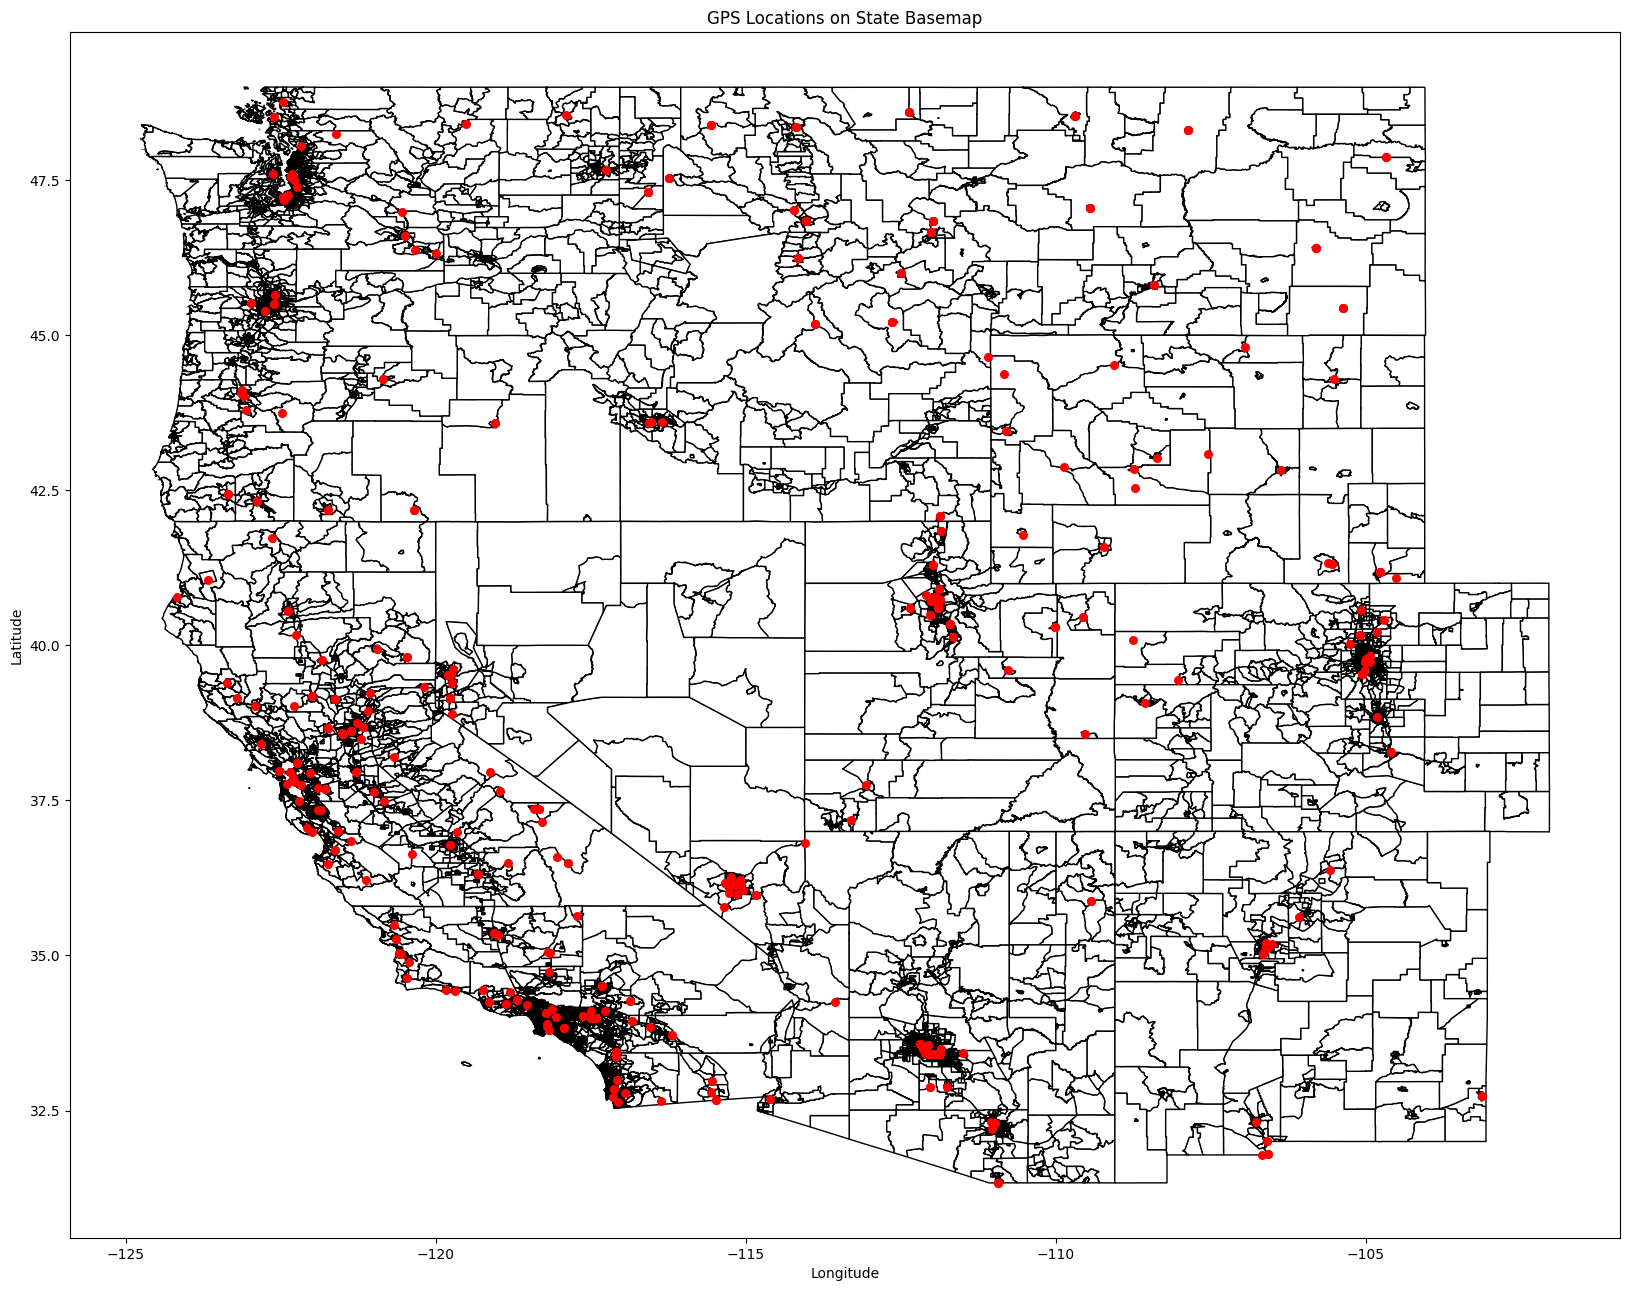

In [117]:
# Plot the state basemap
ax = gdf_converted.plot(color='white', edgecolor='black', figsize=(20, 20))

# Plot GPS locations on top of the state basemap
df4_gdf.plot(ax=ax, color='red', markersize=30)

# Set title and show the plot
plt.title('GPS Locations on State Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()